# Obtaining and using ERA-Interim reanalysis

– Ethan Campbell

The Python file ``erai_tools.py`` includes utilities that I've written to download, process, load, and interact with ECMWF ERA-Interim reanalysis fields. The file can be treated as a Python module, which can be loaded using, e.g., ``import erai_tools as et``.

## What fields I have obtained

I've used the function ``et.ecmwf()`` and code in ``main()`` to submit an ECMWF MARS API request for the following ERA-Interim fields, which span 2018-10-10 to 2019-03-31 and are on the standard 0.75° x 0.75° grid:
* ``erai_SH_analysis.nc`` (Southern Hemisphere; area: 53-90°S, 180°W-180°E)
* ``erai_NH_analysis.nc`` (Northern Hemisphere; area: 55-90°N, 180°W-180°E)
* ``erai_SH_forecast.nc`` (as above)
* ``erai_NH_forecast.nc`` (as above)

See [this documentation](https://confluence.ecmwf.int/pages/viewpage.action?pageId=56658233) for the difference between ERA-I analysis and forecast fields. The analysis fields include the following variables:
* ``skt`` - Skin temperature (°C)
* ``t2m`` - Temperature at 2 meters (°C)
* ``u10``, ``v10`` - U, V wind components at 10 m (m/s)
* ``si10`` - 10-m wind speed from 'u10' and 'v10' (m/s)

The forecast fields contain the following variables:
* ``tp`` - Precipitation rate (m/s)
* ``sf`` - Snowfall rate (m/s)

After submitting the MARS request, I downloaded the fields from ECMWF, then processed them using the function ``et.load_ecmwf()``.

## Loading the data into Pangeo

A zipped directory ``Data`` (size: 300 MB) containing these fields can be obtained from the following Google Drive link:
[https://drive.google.com/file/d/1E9rC-Ld3aywdNKgoSLC41u699asaSJPi/view?usp=sharing](https://drive.google.com/file/d/1E9rC-Ld3aywdNKgoSLC41u699asaSJPi/view?usp=sharing)

From the command line and within our cloned SnowBlower repo, this directory can be downloaded and unzipped using the ``gdown`` utility. Execute the following lines:

* ``pip install gdown``
* ``gdown https://drive.google.com/uc?id=1E9rC-Ld3aywdNKgoSLC41u699asaSJPi``
* ``unzip Data.zip``
* ``rm Data.zip``

## Example: creating time series from the data

The function ``et.load_ecmwf()`` can be used to load the ERA-Interim NetCDF files into an ``xarray`` DataArray.

In [1]:
from numpy import *
import xarray as xr
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.interpolate as spin
import pandas.plotting._converter as pandacnv   # only necessary due to Pandas 0.21.0 bug with Datetime plotting
pandacnv.register()
from datetime import datetime, timedelta
import os

import erai_tools as et

erai_SH_forecast = et.load_ecmwf('Data/ERA_Interim_processed/','erai_SH_forecast.nc')

The structure of ``xarray`` files can be explored easily:

In [2]:
erai_SH_forecast

<xarray.Dataset>
Dimensions:  (lats: 50, lons: 480, time: 692)
Coordinates:
  * lons     (lons) float32 -180.0 -179.25 -178.5 ... 177.75 178.5 179.25
  * lats     (lats) float32 -53.25 -54.0 -54.75 -55.5 ... -88.5 -89.25 -90.0
  * time     (time) datetime64[ns] 2018-10-10T06:00:00 ... 2019-04-01
    doy      (time) float64 dask.array<shape=(692,), chunksize=(100,)>
Data variables:
    tp       (time, lats, lons) float32 dask.array<shape=(692, 50, 480), chunksize=(100, 50, 480)>
    sf       (time, lats, lons) float32 dask.array<shape=(692, 50, 480), chunksize=(100, 50, 480)>
Attributes:
    Conventions:  CF-1.6
    history:      2019-06-18 08:49:35 GMT by grib_to_netcdf-2.12.0: grib_to_n...

Next, the utility ``et.create_reanalysis_series()`` can be used to create a Pandas time series of a single variable at a given location (``nearest_to_lat_lon``):

In [5]:
# Maud Rise snowfall (65°S, 0°E)
erai_snowfall_maud_rise = et.create_reanalysis_series(erai_SH_forecast,param_name='sf',nearest_to_lat_lon=(-65,0))

# first 5 elements, as an example...
erai_snowfall_maud_rise[0:5]

time
2018-10-10 06:00:00    4.746141e-10
2018-10-10 12:00:00    5.555023e-10
2018-10-10 18:00:00    1.330704e-10
2018-10-11 00:00:00   -1.733724e-12
2018-10-11 06:00:00    4.320100e-11
dtype: float32

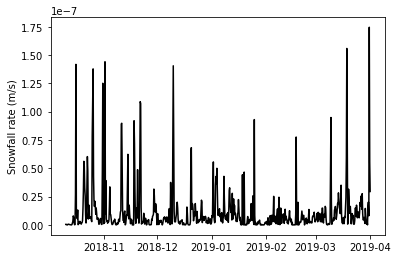

In [6]:
%matplotlib inline
plt.figure()
plt.plot(erai_snowfall_maud_rise,'k')
plt.ylabel('Snowfall rate (m/s)');

The utility ``et.create_reanalysis_series()`` can also calculate average values within a bounding box (``avg_box``), representing \[lon_E,lon_W,lat_S,lat_N\]:

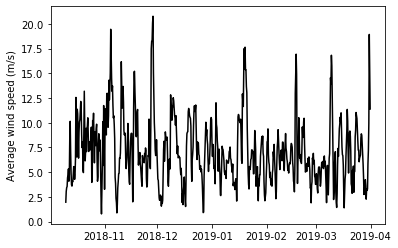

In [8]:
erai_SH_analysis = et.load_ecmwf('Data/ERA_Interim_processed/','erai_SH_analysis.nc')

# average wind speed from 64-66°S, 5°W-0°E:
erai_ws_maud_rise = et.create_reanalysis_series(erai_SH_analysis,param_name='si10',avg_box=[-5,0,-66,-64])

# plot
plt.figure()
plt.plot(erai_ws_maud_rise,'k')
plt.ylabel('Average wind speed (m/s)');

It's easy to index into the Pandas series, using, e.g.:

In [9]:
erai_ws_maud_rise.loc['2019-02-01']

time
2019-02-01 00:00:00    5.715244
2019-02-01 06:00:00    8.072490
2019-02-01 12:00:00    8.115422
2019-02-01 18:00:00    9.372627
dtype: float32

In [10]:
mean(erai_ws_maud_rise.loc['2019-02-01'])

7.81894588470459

In [11]:
erai_ws_maud_rise.loc['2019-02-02-06':'2019-02-02-12']

time
2019-02-02 06:00:00    6.032369
2019-02-02 12:00:00    5.725710
dtype: float32

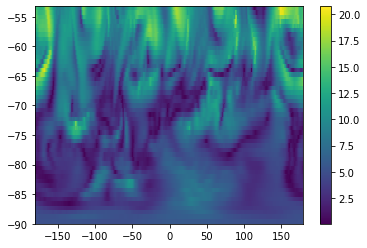

In [12]:
x_grid,y_grid = meshgrid(erai_SH_forecast.lons,erai_SH_forecast.lats)
plt.pcolormesh(x_grid,y_grid,erai_SH_analysis.si10.loc['2019-01-02-12'].values)
plt.colorbar()

Text(0, 0.5, 'Sky condition (oktas [0-8])')

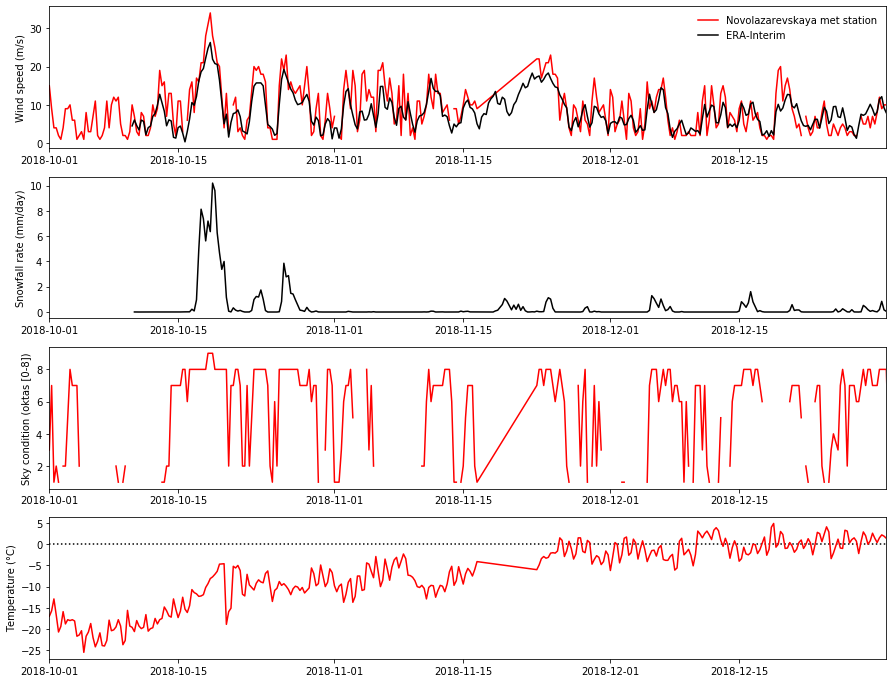

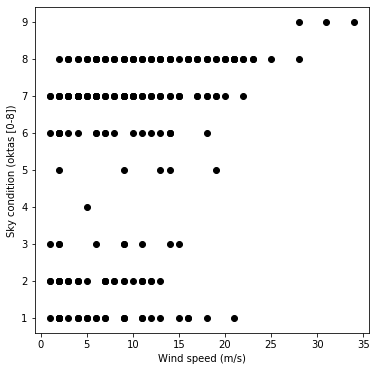

In [15]:
import pickle
novo_met = pickle.load(open('Novo_met','rb'))
novo_met.keys()

novo_loc = (-70.8,11.8)

erai_SH_analysis = et.load_ecmwf('Data/ERA_Interim_processed/','erai_SH_analysis.nc')
erai_ws_novo = et.create_reanalysis_series(erai_SH_analysis,param_name='si10',nearest_to_lat_lon=novo_loc)
erai_sf_novo = et.create_reanalysis_series(erai_SH_forecast,param_name='sf',nearest_to_lat_lon=novo_loc)

fig = plt.figure(figsize=(15,12))
plt.subplot(4,1,1)
plt.plot(novo_met['ws'].loc['2018-10-01':'2018-12-31'],c='r',label='Novolazarevskaya met station')
plt.plot(erai_ws_novo.loc['2018-10-01':'2018-12-31'],c='k',label='ERA-Interim')
plt.xlim(['2018-10-01','2018-12-31'])
plt.legend(loc='upper right',frameon=False)
plt.ylabel('Wind speed (m/s)')
plt.subplot(4,1,2)
plt.plot(erai_sf_novo.loc['2018-10-01':'2018-12-31']*1000*60*60*12,c='k')
plt.xlim(['2018-10-01','2018-12-31'])
plt.ylabel('Snowfall rate (mm/day)')
plt.subplot(4,1,3)
plt.plot(novo_met['sky'].loc['2018-10-01':'2018-12-31'],c='r')
plt.xlim(['2018-10-01','2018-12-31'])
plt.ylabel('Sky condition (oktas [0-8])')
plt.subplot(4,1,4)
plt.plot([datetime(2018,10,1),datetime(2018,12,31)],[0,0],c='k',ls=':')
plt.plot(novo_met['temp'].loc['2018-10-01':'2018-12-31'],c='r')
plt.xlim(['2018-10-01','2018-12-31'])
plt.ylabel('Temperature (°C)')

plt.figure(figsize=(6,6))
# plt.subplot(1,2,1)
plt.scatter(novo_met['ws'].loc['2018-10-01':'2018-12-31'],novo_met['sky'].loc['2018-10-01':'2018-12-31'],c='k')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Sky condition (oktas [0-8])')

In [38]:
# 6-hourly windows at Novo Station with high wind speeds (>= 8 m/s) and little cloud cover (<= 3 oktas)
high_wind_few_cloud_mask = logical_and(novo_met['ws'].loc['2018-10-01':'2018-12-31'] >= 8.0,
                                       novo_met['sky'].loc['2018-10-01':'2018-12-31'] <= 3)
high_wind_few_cloud_mask[high_wind_few_cloud_mask == False] = NaN
high_wind_few_cloud_mask = high_wind_few_cloud_mask.dropna()
high_wind_few_cloud_mask.index

DatetimeIndex(['2018-10-01 00:00:00', '2018-10-02 18:00:00',
               '2018-10-08 06:00:00', '2018-10-08 12:00:00',
               '2018-10-13 06:00:00', '2018-10-13 12:00:00',
               '2018-10-14 00:00:00', '2018-10-30 06:00:00',
               '2018-11-04 00:00:00', '2018-11-04 18:00:00',
               '2018-11-05 06:00:00', '2018-11-06 06:00:00',
               '2018-11-14 00:00:00', '2018-11-14 06:00:00',
               '2018-11-15 00:00:00', '2018-11-16 06:00:00',
               '2018-11-16 12:00:00', '2018-11-26 06:00:00',
               '2018-11-29 00:00:00', '2018-11-29 12:00:00',
               '2018-11-30 00:00:00', '2018-12-02 06:00:00',
               '2018-12-05 00:00:00', '2018-12-11 00:00:00',
               '2018-12-14 00:00:00', '2018-12-24 00:00:00',
               '2018-12-24 06:00:00', '2018-12-31 06:00:00'],
              dtype='datetime64[ns]', freq=None)

In [39]:
hem_abbrev = 'SH'
erai_analysis = et.load_ecmwf('Data/ERA_Interim_processed/','erai_{0}_analysis.nc'.format(hem_abbrev))
erai_forecast = et.load_ecmwf('Data/ERA_Interim_processed/','erai_{0}_forecast.nc'.format(hem_abbrev))

def datetime_to_datenum(datetime_vector):
    return mdates.datestr2num([str(dt) for dt in datetime_vector])

def series_interp(orig_series,new_index,day_interval=(1/24)):
    # note: new_index can be a single Datetime or a range of Datetimes, e.g. [start,end]
    interpolator = spin.interp1d(datetime_to_datenum(orig_series.index),orig_series.values,
                                 bounds_error=False,fill_value=NaN)
    if not isinstance(new_index,datetime):
        new_index = arange(*new_index,timedelta(days=day_interval))
    else:
        new_index = [new_index]
    interp_data = interpolator(datetime_to_datenum(new_index))
    return pd.Series(index=new_index,data=interp_data)

def loc_history(lat,lon,this_dt,erai_fields=[erai_analysis,erai_forecast],prior_days=2.0):
    erai_analysis_subset = erai_fields[0].sel(time=slice(this_dt-timedelta(days=prior_days+1.0),
                                                         this_dt+timedelta(days=1.0)))
    erai_forecast_subset = erai_fields[1].sel(time=slice(this_dt-timedelta(days=prior_days+1.0),
                                                         this_dt+timedelta(days=1.0)))
    
    time_range = [this_dt-timedelta(days=prior_days),this_dt]

    recent_sf = et.create_reanalysis_series(erai_forecast_subset,param_name='sf',nearest_to_lat_lon=(lat,lon))
    recent_ws = et.create_reanalysis_series(erai_analysis_subset,param_name='si10',nearest_to_lat_lon=(lat,lon))
    recent_t2m = et.create_reanalysis_series(erai_analysis_subset,param_name='t2m',nearest_to_lat_lon=(lat,lon))
    recent_sf_series = series_interp(recent_sf,time_range)
    recent_ws_series = series_interp(recent_ws,time_range)
    recent_t2m_series = series_interp(recent_t2m,time_range)
    
    data_dict = {'current':{'snowfall_rate':recent_sf_series[-1],
                            'wind_speed_10_m':recent_ws_series[-1],
                            'temp_2_m':recent_t2m_series[-1]},
                 'recent_mean':{'snowfall_rate':mean(recent_sf_series),
                           'wind_speed_10_m':mean(recent_ws_series),
                           'temp_2_m':mean(recent_t2m_series)},
                 'recent_max':{'snowfall_rate':max(recent_sf_series),
                               'wind_speed_10_m':max(recent_ws_series),
                               'temp_2_m':max(recent_t2m_series)}}
    return data_dict

def along_track(lats,lons,datetimes,erai_fields=[erai_analysis,erai_forecast],prior_days=2.0,
                temporal='recent_mean',param='snowfall_rate'):
    """
    Args:
        lats, lons: NumPy arrays of along-track latitudes and longitudes
        datetimes: NumPy arrays of along-track Datetime objects
        prior_days: number of days over which to calculate averages or maxima
        temporal: {'current','recent_mean','recent_max'}
        param: {'snowfall_rate','wind_speed_10_m','temp_2_m'}
        
    """
    return array([loc_history(lats[t_idx],lons[t_idx],datetimes[t_idx],erai_fields=[erai_analysis,erai_forecast],
                              prior_days=prior_days)[temporal][param] for t_idx in range(0,len(datetimes))])

# SAMPLE USAGE
lats = [-65,-66,-67]
lons = [5,6,7]
datetimes = [datetime(2018,12,25,4),datetime(2018,12,25,8),datetime(2018,12,25,12)]

print('Along-track snowfall rate (in m/s) from the past 2 days at each location:')
print(along_track(lats,lons,datetimes,temporal='recent_mean',param='snowfall_rate',prior_days=2.0))

print('Current along-track wind speed (in m/s):')
print(along_track(lats,lons,datetimes,temporal='current',param='wind_speed_10_m'))

Along-track snowfall rate (in m/s) from the past 2 days at each location:
[2.15566528e-09 4.20734746e-09 3.28127777e-09]
Current along-track wind speed (in m/s):
[ 9.90189695 11.31874911 10.0311087 ]
